# Attempting to stabilise the model with hyperdiffusion

## Without hyperdiffusion: model crashes at $t = 2.31 \times 10^6$

In [1]:
import xarray as xr
import numpy as np
import dedalus.public as d3
from IPython.display import Video
import matplotlib.pyplot as plt
import h5py

import modules.math as math

In [106]:
Video('../data/restest_highRa_1024_128/restest_highRa_1024_128_s1.mp4')

This is probably not due to the time step, since $C < 1$ everywhere, except at the point where the model blows up:

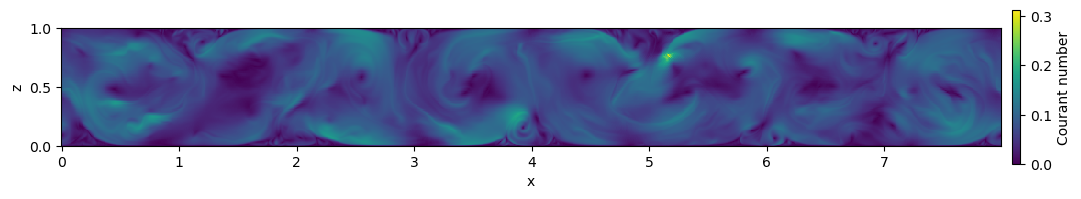

In [109]:
highRa = xr.open_mfdataset(
    '../data/restest_highRa_1024_128/*.nc', 
    chunks={'t': 1000, 'x': 128, 'z': 128})

def courant_number(data):
    diff_x = np.diff(data.x)
    dx = (
        np.concatenate([[diff_x[0]], diff_x])
        + np.concatenate([diff_x, [diff_x[-1]]])
    )/2
    diff_z = np.diff(data.z)
    dz = (
        np.concatenate([[diff_z[0]], diff_z])
        + np.concatenate([diff_z, [diff_z[-1]]])
    )/2
    C = np.sqrt(
        (np.abs(data.u)/np.atleast_2d(dx).T)**2
        + (np.abs(data.w)/np.atleast_2d(dz))**2
    )*data.timestep
    return C

fig, ax = plt.subplots(figsize=(12, 2), sharex=True)
mesh = ax.pcolormesh(
    highRa.x, highRa.z, courant_number(highRa.isel(t=769)).T, vmin=0)
fig.colorbar(mesh, ax=ax, pad=0.01, label='Courant number')
ax.set(aspect='equal', xlabel='x', ylabel='z')
fig.tight_layout()

Here is a close-up of the singularity:

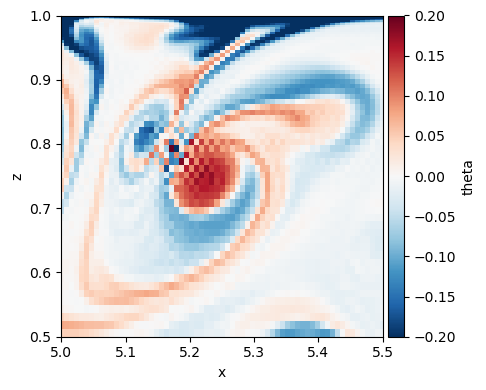

In [111]:
fig, ax = plt.subplots(figsize=(6, 4))
mesh = ax.pcolormesh(
    highRa.x, highRa.z, highRa.theta.isel(t=768).T,
    vmin=-0.2, vmax=0.2, cmap='RdBu_r')
fig.colorbar(mesh, ax=ax, pad=0.01, label='theta')
ax.set(
    aspect='equal', xlabel='x', ylabel='z', xlim=(5.0, 5.5), ylim=(0.5, 1.0))
fig.tight_layout()

## With hyperdiffusion: model crashes at unpredictable times
I now add 4th-order hyperdiffusion terms $-\tilde{\nu} \nabla^4$ to the momentum and energy equations, choosing the hyperdiffusion coefficient $\tilde{\nu} = 10^{-7}$. In order to avoid needing to specify additional boundary conditions, the hyperdiffusion is reduced to zero at the boundaries using a factor $f(z) = 1 - (2z - 1)^{10}$. The equations in full are

$$
\begin{align*}
    \mathrm{Ra}\,\mathrm{Pr}^{-1} \left( \partial_t \vec{u} + \vec{u} \cdot \vec{\nabla} \vec{u} \right)
        &= -\vec{\nabla} \pi + \nabla^2 \vec{u} - \tilde{\nu} f(z) \nabla^4 \vec{u} + \theta \hat{z}, \\
    \mathrm{Ra} \left( \partial_t \theta + \vec{u} \cdot \vec{\nabla} \theta \right)
        &= \nabla^2 \theta - \tilde{\nu} f(z) \nabla^4 \theta, \\
    \vec{\nabla} \cdot \vec{u} &= 0
\end{align*}
$$

In [3]:
Video('../data/restest_highRa_hyper_1024_128/restest_highRa_hyper_1024_128_s1.mp4')

In [4]:
Video('../data/restest_hyper_logterms_1024_128/restest_hyper_logterms_1024_128_s1.mp4')

Re-running the model with the exact same parameters seems to give different results! The data are the same for roughly the first half of the run then gradually diverge.

### Model output
I have asked Dedalus to calculate and record the terms contributing to $\partial_t u$, $\partial_t w$ and $\partial_t \theta$ as diagnostic variables. In particular, I have saved the hyperdiffusion term both with and without the tapering function. I plot the terms below at a chosen time step.

In [15]:
with h5py.File('../data/restest_hyper_logterms_1024_128/terms/terms_s1.h5', mode='r') as file:
    u_terms = {
        'advection': file['tasks']['-1*u@Grad(u)'][:,0,:,:],
        'hyperdiffusion': file['tasks']['-1e-16*<Field 140342512184144>*Lap(Lap(u))'][:,0,:,:],
        'hyperdiffusion_notaper': file['tasks']['-1e-16*Lap(Lap(u))'][:,0,:,:],
        'diffusion': file['tasks']['1e-09*Lap(u)'][:,0,:,:],
    }
    w_terms = {
        'advection': file['tasks']['-1*u@Grad(u)'][:,1,:,:],
        'hyperdiffusion': file['tasks']['-1e-16*<Field 140342512184144>*Lap(Lap(u))'][:,1,:,:],
        'hyperdiffusion_notaper': file['tasks']['-1e-16*Lap(Lap(u))'][:,1,:,:],
        'diffusion': file['tasks']['1e-09*Lap(u)'][:,1,:,:],
    }
    theta_terms = {
        'advection': file['tasks']['-1*u@Grad(theta)'][:],
        'hyperdiffusion': file['tasks']['-1e-16*<Field 140342514746832>*Lap(Lap(theta))'][:],
        'hyperdiffusion_notaper': file['tasks']['-1e-16*Lap(Lap(theta))'][:],
        'diffusion': file['tasks']['1e-09*Lap(theta)'][:],
    }
    x = file['scales']['x_hash_bce6f23fa9cbb7672fe5650707ea50f83fb4bc76'][:]
    z = file['scales']['z_hash_d284f597a983ade9304b26b4bf92bfe0a3d1d846'][:]
    t = file['scales']['sim_time'][:]

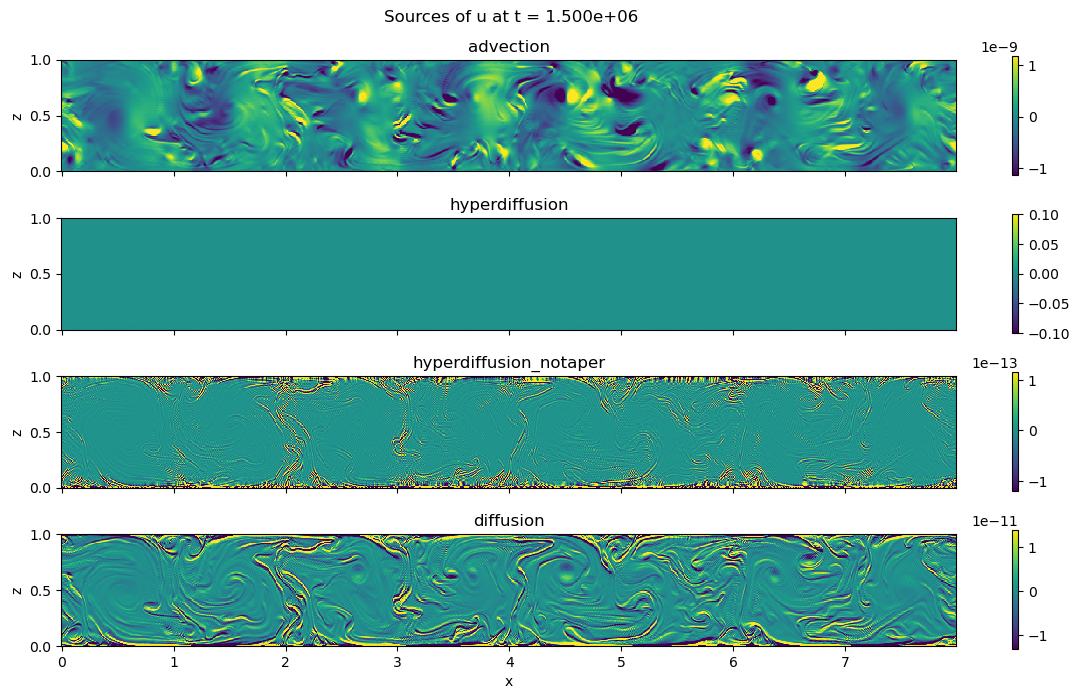

In [19]:
i_time = 25
fig, axes = plt.subplots(4, 1, figsize=(12, 7), sharex=True)

quantiles = [0.01, 0.1, 0.1, 0.1]
for i, term in enumerate(u_terms.keys()):
    array = u_terms[term][i_time, :, :]
    mesh = axes[i].pcolormesh(x, z, array.T, shading='nearest')
    mesh.set_clim(
        np.quantile(array, quantiles[i]), np.quantile(array, 1 - quantiles[i]))
    axes[i].set(aspect='equal', ylabel='z', title=term)
    fig.colorbar(mesh, ax=axes[i])

axes[-1].set_xlabel('x')
fig.suptitle(f'Sources of u at t = {t[i_time]:.3e}', x=0.43)
fig.tight_layout()

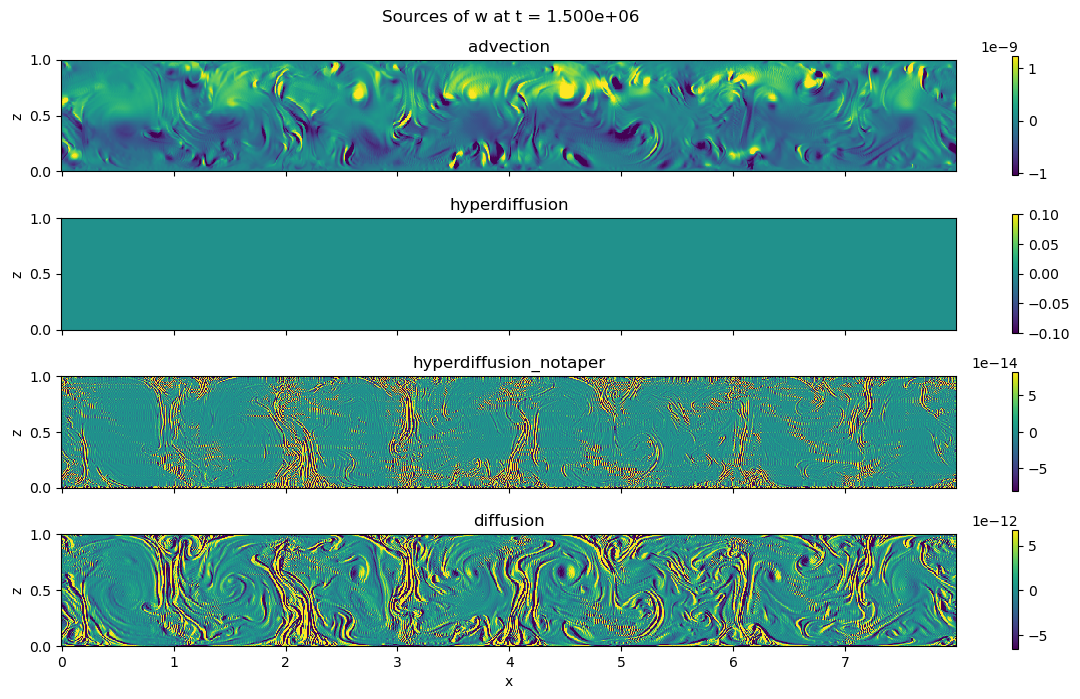

In [20]:
i_time = 25
fig, axes = plt.subplots(4, 1, figsize=(12, 7), sharex=True)

quantiles = [0.01, 0.1, 0.1, 0.1]
for i, term in enumerate(w_terms.keys()):
    array = w_terms[term][i_time, :, :]
    mesh = axes[i].pcolormesh(x, z, array.T, shading='nearest')
    mesh.set_clim(
        np.quantile(array, quantiles[i]), np.quantile(array, 1 - quantiles[i]))
    axes[i].set(aspect='equal', ylabel='z', title=term)
    fig.colorbar(mesh, ax=axes[i])

axes[-1].set_xlabel('x')
fig.suptitle(f'Sources of w at t = {t[i_time]:.3e}', x=0.43)
fig.tight_layout()

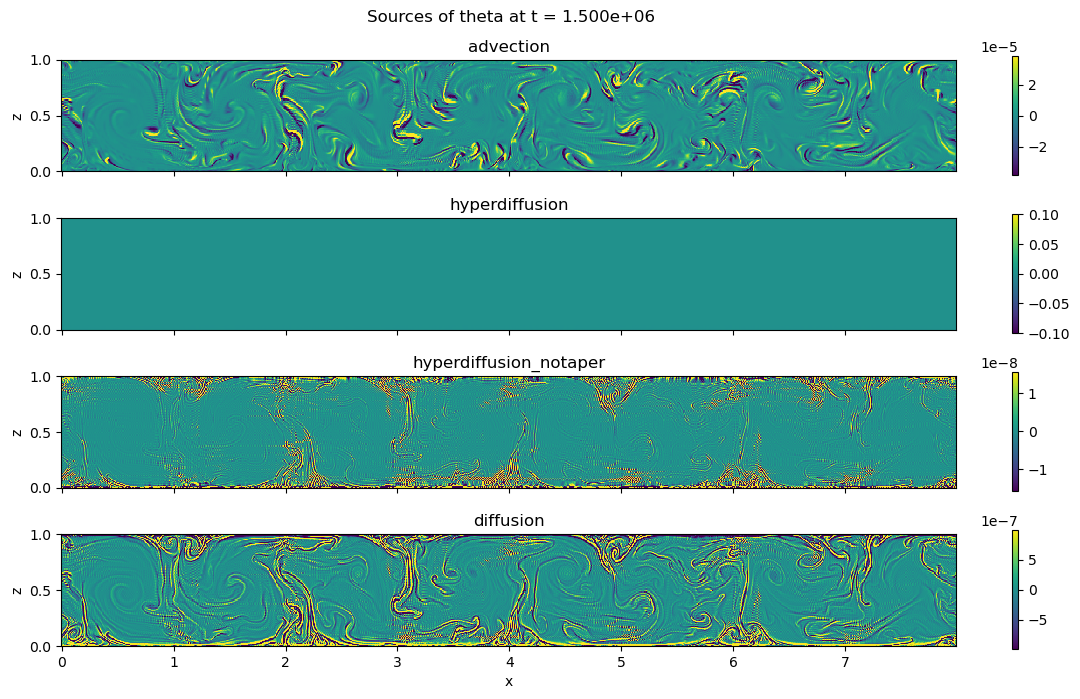

In [21]:
i_time = 25
fig, axes = plt.subplots(4, 1, figsize=(12, 7), sharex=True)

quantiles = [0.01, 0.1, 0.1, 0.1]
for i, term in enumerate(theta_terms.keys()):
    array = theta_terms[term][i_time, :, :]
    mesh = axes[i].pcolormesh(x, z, array.T, shading='nearest')
    mesh.set_clim(
        np.quantile(array, quantiles[i]), np.quantile(array, 1 - quantiles[i]))
    axes[i].set(aspect='equal', ylabel='z', title=term)
    fig.colorbar(mesh, ax=axes[i])

axes[-1].set_xlabel('x')
fig.suptitle(f'Sources of theta at t = {t[i_time]:.3e}', x=0.43)
fig.tight_layout()

Clearly, the tapering function is interfering with the calculation of the hyperdiffusion term.

### Checking the magnitude of each term in the equations
As a sanity check, I repeat the above analysis, now using the output data to calculate the terms myself using finite differences rather than relying on Dedalus.

In [27]:
def laplacian(data):
    result = (
        data.differentiate('x').differentiate('x')
        + data.differentiate('z').differentiate('z')
    )
    return result

Rayleigh = 1e9
Prandtl = 1
hyper = 1e-7

def calculate_terms(data, i_time):
    u = data.u.isel(t=i_time)
    w = data.w.isel(t=i_time)
    theta = data.theta.isel(t=i_time)

    taper = 1 - (2*u.z - 1)**10

    u_terms = {
        'advection': (
            u * u.differentiate('x')
            + w * u.differentiate('z')
        ),
        'diffusion': laplacian(u)*Prandtl/Rayleigh,
        'hyperdiffusion': (
            hyper * taper * laplacian(laplacian(u))
        )*Prandtl/Rayleigh
    }
    w_terms = {
        'advection': (
            u * w.differentiate('x')
            + w * w.differentiate('z')
        ),
        'diffusion': laplacian(w)*Prandtl/Rayleigh,
        'hyperdiffusion': (
            hyper * taper * laplacian(laplacian(w))
        )*Prandtl/Rayleigh,
    }
    theta_terms = {
        'advection': (
            u * theta.differentiate('x')
            + w * theta.differentiate('z')
        ),
        'diffusion': laplacian(theta)/Rayleigh,
        'hyperdiffusion': (
            hyper * taper * laplacian(laplacian(theta))
        )/Rayleigh
    }
    return u_terms, w_terms, theta_terms

In [28]:
i_time = 500
data = xr.open_dataset('../data/restest_hyper_logterms_1024_128/restest_hyper_logterms_1024_128_s1.nc')
u_terms, w_terms, theta_terms = calculate_terms(data, i_time)

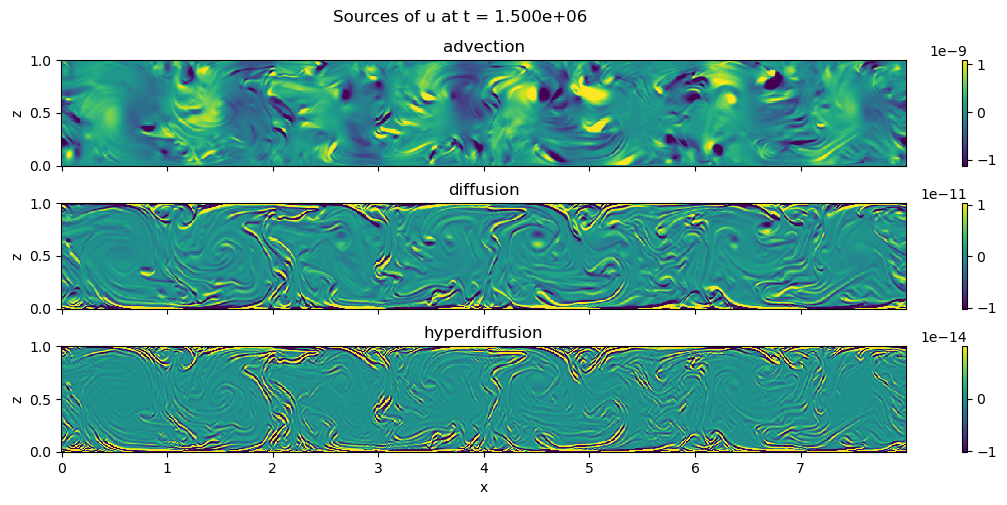

In [24]:
fig, axes = plt.subplots(3, 1, figsize=(12, 5), sharex=True)

quantiles = [0.01, 0.1, 0.1]
for i, term in enumerate(u_terms.keys()):
    array = u_terms[term].transpose('z', 'x')
    mesh = axes[i].pcolormesh(array.x, array.z, array, shading='nearest')
    mesh.set_clim(
        np.quantile(array, quantiles[i]), np.quantile(array, 1 - quantiles[i]))
    axes[i].set(aspect='equal', ylabel='z', title=term)
    fig.colorbar(mesh, ax=axes[i])

axes[-1].set_xlabel('x')
fig.suptitle(f'Sources of u at t = {data.t[i_time]:.3e}', x=0.43)
fig.tight_layout()

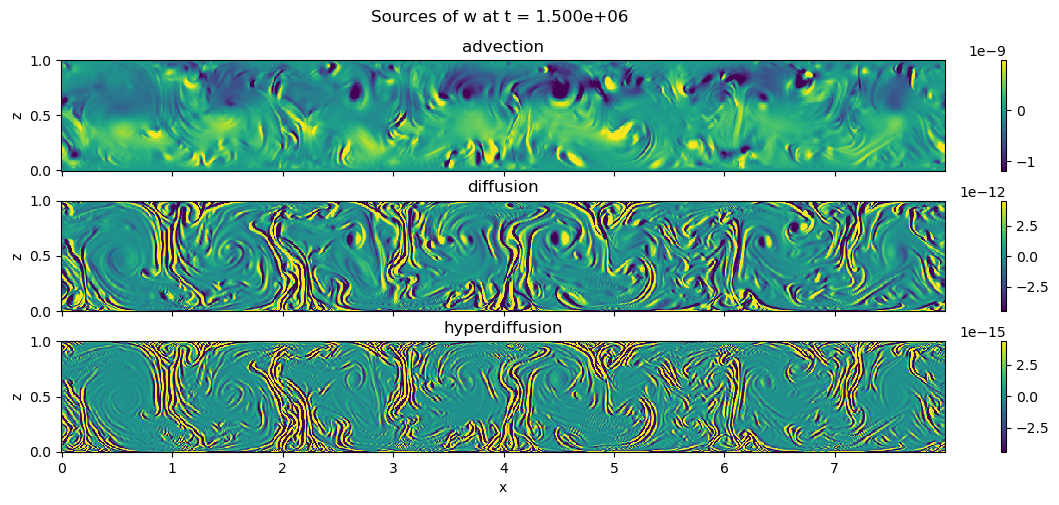

In [30]:
fig, axes = plt.subplots(3, 1, figsize=(12, 5), sharex=True)

quantiles = [0.01, 0.1, 0.1]
for i, term in enumerate(w_terms.keys()):
    array = w_terms[term].transpose('z', 'x')
    mesh = axes[i].pcolormesh(array.x, array.z, array, shading='nearest')
    mesh.set_clim(
        np.quantile(array, quantiles[i]), np.quantile(array, 1 - quantiles[i]))
    axes[i].set(aspect='equal', ylabel='z', title=term)
    fig.colorbar(mesh, ax=axes[i])

axes[-1].set_xlabel('x')
fig.suptitle(f'Sources of w at t = {data.t[i_time]:.3e}', x=0.43)
fig.tight_layout()

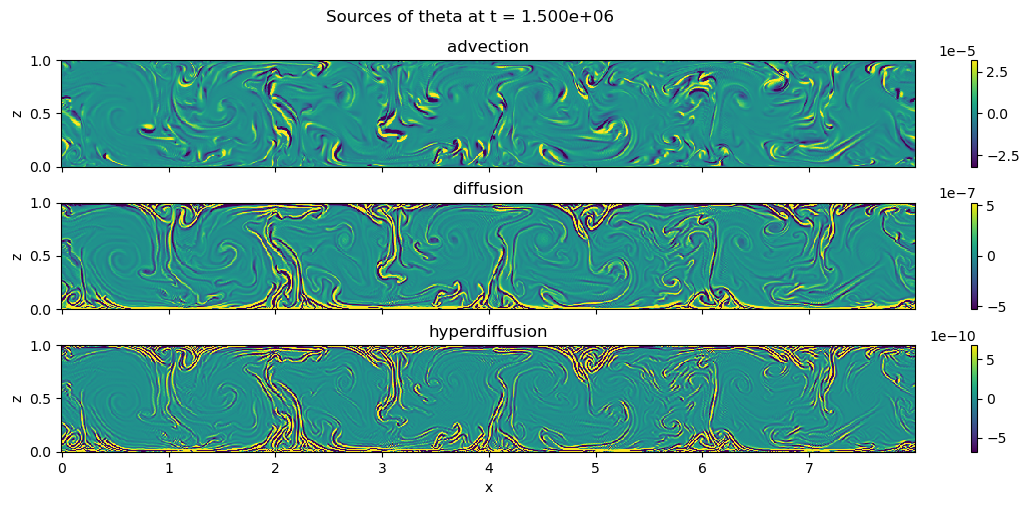

In [26]:
fig, axes = plt.subplots(3, 1, figsize=(12, 5), sharex=True)

quantiles = [0.01, 0.1, 0.1]
for i, term in enumerate(theta_terms.keys()):
    array = theta_terms[term].transpose('z', 'x')
    mesh = axes[i].pcolormesh(array.x, array.z, array, shading='nearest')
    mesh.set_clim(
        np.quantile(array, quantiles[i]), np.quantile(array, 1 - quantiles[i]))
    axes[i].set(aspect='equal', ylabel='z', title=term)
    fig.colorbar(mesh, ax=axes[i])

axes[-1].set_xlabel('x')
fig.suptitle(f'Sources of theta at t = {data.t[i_time]:.3e}', x=0.43)
fig.tight_layout()

Interestingly, there are no artefacts or other issues in the advection, diffusion and hyperdiffusion fields when they are calculated using finite differences after the fact.

### Conclusion
It appears that, while linear hyperdiffusion should work in theory, it fails in practice due to an unknown technicality in Dedalus.